In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os, os.path
from scipy import optimize, interpolate, signal
from scipy.fftpack import fft, fftfreq
import itertools
import pathlib
from pathlib import Path
from typing import List, Tuple

## 2theta-omega

In [79]:
class XRD:
    def __init__(self, sample, filepath_2tw, filepath_r006, filepath_r0015):
        self.SAMPLE = sample
        self.filepath_2tw = filepath_2tw
        self.filepath_r006 = filepath_r006
        self.filepath_r0015 = filepath_r0015
        self.filedir = Path(os.path.dirname(filepath_2tw))
        self.df = pd.read_csv(self.filepath_2tw, skiprows=2, delimiter="\\s")

        # 低角反射の設定
        self.two_theta_min = 1
        self.two_theta_max = 5
        self.t_upperbound = 200  # nm

    def run(self):
        csv_2tw = self.two_theta_omega()
        param_opti = self.extract_low_angle()
        csv_2tw_fft = self.detect_thickness()
        # self.laue_fringe()
        csv_r006 = self.rocking(self.filepath_r006, title="(006) rocking")
        csv_r0015 = self.rocking(self.filepath_r0015, title="(0015) rocking")
        self.integrate_data(
            [csv_2tw, csv_2tw_fft, csv_r006, csv_r0015], \
            prefix_list=[f"_{self.SAMPLE}_2tw", f"_{self.SAMPLE}_2tw_fft", f"_{self.SAMPLE}_r006", f"_{self.SAMPLE}_r0015"]
            )
    
    def integrate_data(self, path_list, prefix_list):
        """Igorの読み込みを楽にするためにすべてのcsvを一つに結合する

        Args:
            path_listmprefix_list (_type_): _description_

        Returns:
            _type_: _description_
        """
        df_master = pd.DataFrame([])
        for path, prefix in zip(path_list, prefix_list):
            tmp = pd.read_csv(path, index_col=None)
            tmp = tmp.rename(columns={col: col + prefix for col in tmp.columns})
            df_master = pd.concat([df_master, tmp], axis=1)
        df_master.to_csv(self.filedir / "df_master.csv", index=False)
        return None


    def two_theta_omega(self) -> Tuple[pd.DataFrame, pathlib.PosixPath]:
        xrd_lambda = 1.540598 # Kα（カッパアルファ1）の波長
        filename, _ = os.path.splitext(os.path.basename(self.filepath_2tw))

        self.df.columns = ["2theta", "int"]
        self.df["int"] += 1.0
        csv_path = self.filedir / f"{filename}_plus1.csv"
        self.df.to_csv(csv_path, index = False)

        self.df["q"] = 4 * np.pi * np.sin(self.df["2theta"] * np.pi / 360)/ xrd_lambda # q = 4πsin(θ)/λ
        # qは散乱ベクトルの大きさを表す
        self.df["q_lnsp"] = np.linspace(np.min(self.df["q"]), np.max(self.df["q"]), np.size(self.df["q"])) # qの等間隔な配列
        lar_intp = interpolate.interp1d(self.df["q"],self. df["int"]) # qの等間隔な配列に対応するように補間
        self.df["int_log"] = np.log(lar_intp(self.df["q_lnsp"]) + 1) # 補間した値を対数変換

        plt.figure(figsize = (18, 6))
        plt.plot(self.df["2theta"], self.df["int_log"], color="red")
        plt.show()
        return csv_path


    def extract_low_angle(self) -> List[float]:
        # 低角反射（two_theta_min~two_theta_max）で膜厚を求める


        self.df_trim = self.df.loc[self.df.index[(self.df["2theta"] > self.two_theta_min) & (self.df["2theta"] < self.two_theta_max)].tolist()]  # 低角反射のみ抽出

        ###############################################
        def xrd_ref_bg(q, a, b, c):  # XRD強度の背景
            return -a * np.log10((q - b)) + c
        ###############################################

        param_a = np.linspace(0.1, 500, 51)
        param_b = np.linspace(-10, 0, 16)
        param_c = np.linspace(-5, 5, 11)

        for a, b, c in itertools.product(param_a, param_b, param_c):
            # print(a, b, c)
            param_init = [a, b, c]
            try:
                param_opti, _ = optimize.curve_fit(xrd_ref_bg, self.df_trim["q_lnsp"].values, self.df_trim["int_log"].values, p0=param_init)  # 最適化
            except (RuntimeError) as e:
                # print("cannot optimize")
                continue
            if np.isnan(param_opti).any():
                # print("cannot optimize")
                continue
            print(param_opti)
            self.df_trim["int_bg_log"] = xrd_ref_bg(self.df_trim.loc[:, "q_lnsp"], *param_opti)
            self.df_trim["int_osci"] = self.df_trim["int_log"] - self.df_trim["int_bg_log"]
            plt.subplot(2, 1, 1)
            plt.plot(self.df_trim["q_lnsp"], self.df_trim["int_log"], color="red")
            plt.xlabel("angle(deg)")
            plt.ylabel("intensity")
            plt.plot(self.df_trim["q_lnsp"], self.df_trim["int_bg_log"], color="blue")
            # plt.title("contradict from ")
            plt.subplot(2, 1, 2)
            plt.plot(self.df_trim["q_lnsp"], self.df_trim["int_osci"], color="red")
            plt.xlabel("q")
            plt.ylabel("intensity")
            # plt.title("contradict from ")
            plt.savefig(str(self.filedir / "2tw_low_angle.png"), format="png", dpi=300)
            plt.show()
            break
        return param_opti

    def laue_fringe(self):
        # NOTE: 未完成
        # ラウエフリンジの解析（各レイヤー層での干渉．(sinN/N)^2(0次の場合)のフィッティング）
        two_theta_min = 14 #(0015)のピークが入る範囲を勘で定める
        two_theta_max = 23
        thick_init = 40 #nm

        df_trim_laue = self.df.loc[self.df.index[(self.df["2theta"] > two_theta_min) & (self.df["2theta"] < two_theta_max)].tolist()]

        plt.plot(df_trim_laue["q"], df_trim_laue["int_log"], color = "red")
        # 初期値推定
        # 2theta_omegaの最大値からd_initを推定
        two_theta_peak = df_trim_laue["2theta"].values[np.argmax(df_trim_laue["int_log"])]
        q_peak = df_trim_laue["q"].values[np.argmax(df_trim_laue["int_log"])]
        d_init = 2 * np.pi / q_peak
        M_init = thick_init / d_init

        def laue_func(q, d, M, A):
            return np.log(np.sin(q * d * M / 2)**2) - np.log(np.sin(q * d / 2)**2) + A

        param_init = [M_init, 10]
        # param_opti, _ = optimize.curve_fit(lambda q, M, A: laue_func(q, d_init, M, A), df_trim["q_lnsp"].values, df_trim["int_log"].values, p0 = param_init)
        # plt.plot(df_trim["q"], laue_func(df_trim["q"].values, d_init, *param_opti))
        plt.plot(df_trim_laue["q"], laue_func(df_trim_laue["q"].values, d_init, M_init, 3), color = "blue")
        plt.ylim(bottom = np.min(df_trim_laue["int_log"]) - 2, top = np.max(df_trim_laue["int_log"]) + 2)
        plt.ylabel("intensity")
        plt.xlabel("q")
        plt.savefig(str(self.filedir / "laue_fringe.png"), format="png", dpi=300)
        plt.show()

    def detect_thickness(self):
        filename, _ = os.path.splitext(os.path.basename(self.filepath_2tw))
        int_fft = fft(self.df_trim["int_osci"].values)  # 低角反射（補正済み）をフーリエ変換
        N = len(self.df_trim["int_osci"])
        q_spacing = np.abs(self.df_trim["q_lnsp"].values[1] - self.df_trim["q_lnsp"].values[0])  # qの間隔
        self.df_trim["q_freq"] = fftfreq(N, q_spacing)  # qの周波数

        # ps = power spectrum
        self.df_trim["int_ps"] = np.abs(int_fft)
        # dq = period of oscillation
        # q_freq = inverse of dq
        self.df_trim["q_period"] = 1 / self.df_trim["q_freq"]
        self.df_trim["thickness"] = 2 * np.pi * self.df_trim["q_freq"] * 0.1

        csv_path = self.filedir / f"{filename}_fft.csv"
        self.df_trim.to_csv(csv_path, index=False)

        plt.plot(self.df_trim["thickness"], self.df_trim["int_ps"], "o-", color="red")
        plt.xlim(0, self.t_upperbound)
        plt.xlabel("thickness (nm)")
        plt.ylabel("power spectrum")
        plt.savefig(str(self.filedir / "thickness.png"), format="png", dpi=300)
        plt.show()

        #### search preak ####
        fft_peak = signal.argrelmax(self.df_trim["int_ps"].values)
        fft_peak_value = self.df_trim["int_ps"].values[fft_peak]
        q_osci = 1 / self.df_trim["q_freq"].values[fft_peak]
        thickness_nm = 2 * np.pi * 0.1 * self.df_trim["q_freq"].values[fft_peak]
        fft_result = np.array([fft_peak_value, q_osci, thickness_nm])
        fft_result = fft_result[:, fft_result[0, :].argsort()[::-1]]
        fft_peak_value = fft_result[0]
        q_osci = fft_result[1]
        thickness_nm = fft_result[2]

        for (i, x) in enumerate(fft_peak_value):
            if i == 0:
                fft_result = ""
            if(thickness_nm[i] > 0 and thickness_nm[i] < self.t_upperbound and x > fft_peak_value[0] * 0.2):
                fft_result += "period of q_oscillation = {:.3f}".format(q_osci[i])
                fft_result += "\nthickness = {:.2f} nm".format(thickness_nm[i])
                fft_result += "\nps = {0:.1f}".format(x)
                fft_result += "\n\n"
        print(fft_result)
        fft_result_path = self.filedir / f"{filename}_fft_summary.txt"
        with open(fft_result_path, mode='w') as f:
            f.write(fft_result)
        
        return csv_path

    def rocking(self, filepath, title="rocking curve"):
        """_description_

        Args:
            filename (str): ファイル名

        Returns:
            _type_: _description_
        """
        # filedir = os.path.dirname(filepath)
        # filebasename = os.path.basename(filepath)
        # filename, fileext = os.path.splitext(filebasename)
        filename, _ = os.path.splitext(os.path.basename(filepath))

        df = pd.read_csv(filepath, skiprows=2, delimiter=" ")
        df.columns = ["omega", "int"]
        plt.plot(df["omega"], df["int"], ".", color="red")

        ###############################################
        def lor(x, a, b, c):
            return c / ((x - a) ** 2 + b)
        ###############################################

        #初期値設定
        int_max = np.max(df["int"].values)
        omega_max = df["omega"].values[np.argmax(df["int"].values)]
        a = omega_max
        b = 1 / 400  # 半値幅0.1くらい
        c = int_max * b
        #fitting
        param_init = [a, b, c]
        param_opti, _ = optimize.curve_fit(lor, df["omega"].values, df["int"].values, p0=param_init, maxfev=1000)
        fit_result = "center: {0:.3f}\nFWHM: {1:.3f}".format(param_opti[0], 2 * np.sqrt(param_opti[1]))
        print(fit_result)
        plt.plot(df["omega"], lor(df["omega"], *param_opti), color="blue")
        plt.xlabel("omega")
        plt.ylabel("intensity")
        plt.title(title)
        print(str(self.filedir / f"{filename}.png"))
        plt.savefig(str(self.filedir / f"{filename}.png"), format="png", dpi=300)
        plt.show()

        #dfにフィッティング結果を詰める
        df["d_omega"] = df["omega"] - param_opti[0]
        df["lor_fit"] = lor(df["omega"], *param_opti)
        # print(df)
        csv_path = self.filedir / f"{filename}.csv"
        df.to_csv(csv_path, index=False)

        #フィッティングパラメータを出力
        fit_result_path = self.filedir / f"{filename}_fit.txt"
        with open(fit_result_path, mode='w') as f:
            f.write(fit_result)
        return csv_path




<ipython-input-79-2ec7590db15b>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.df = pd.read_csv(self.filepath_2tw, skiprows=2, delimiter="\\s")


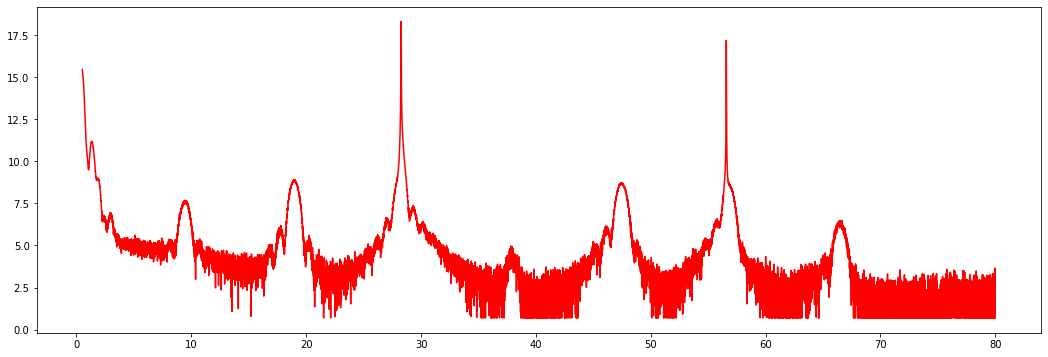

<ipython-input-79-2ec7590db15b>:74: RuntimeWarning: invalid value encountered in log10
  return -a * np.log10((q - b)) + c
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[8.49950601 0.02389153 0.00865994]


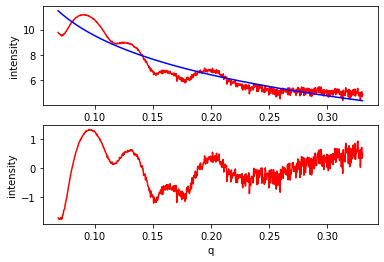

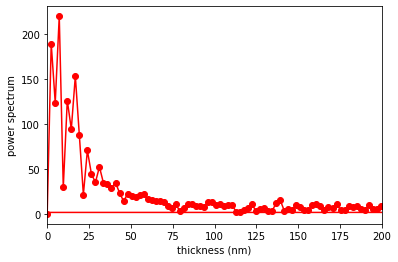

period of q_oscillation = 0.087
thickness = 7.20 nm
ps = 219.5

period of q_oscillation = 0.262
thickness = 2.40 nm
ps = 189.2

period of q_oscillation = 0.037
thickness = 16.80 nm
ps = 153.0

period of q_oscillation = 0.052
thickness = 12.00 nm
ps = 125.9

period of q_oscillation = 0.026
thickness = 24.00 nm
ps = 70.5

period of q_oscillation = 0.020
thickness = 31.21 nm
ps = 52.2


center: 8.781
FWHM: 0.201
/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/#1-1359/rock006.png


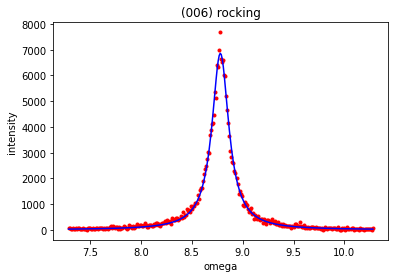

center: 22.438
FWHM: 0.135
/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/#1-1359/rock0015.png


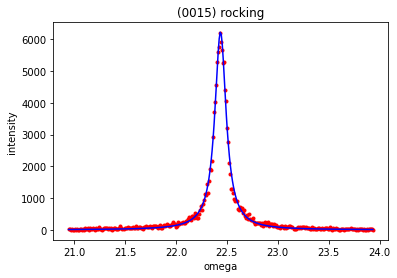

In [80]:
sample = "#1-1359"
filepath_2tw = Path(f"/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/{sample}/2tw.dat")
filepath_r006 = Path(f"/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/{sample}/rock006.dat")
filepath_r0015 = Path(f"/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/{sample}/rock0015.dat")
xrd = XRD(sample, filepath_2tw, filepath_r006, filepath_r0015)
xrd.run()


<ipython-input-79-2ec7590db15b>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.df = pd.read_csv(self.filepath_2tw, skiprows=2, delimiter="\\s")


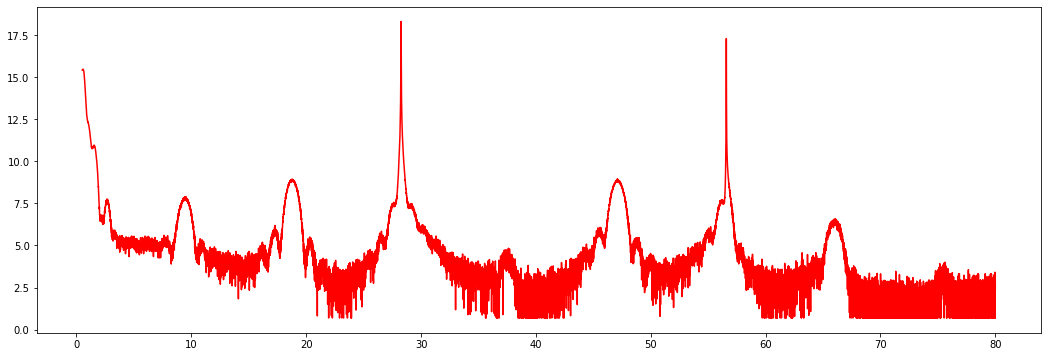

<ipython-input-79-2ec7590db15b>:74: RuntimeWarning: invalid value encountered in log10
  return -a * np.log10((q - b)) + c
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[7.22169512 0.05209431 0.44171574]


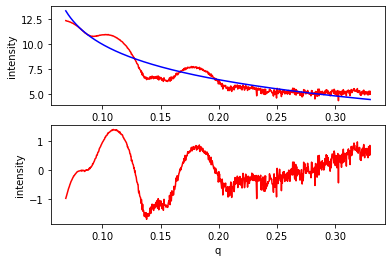

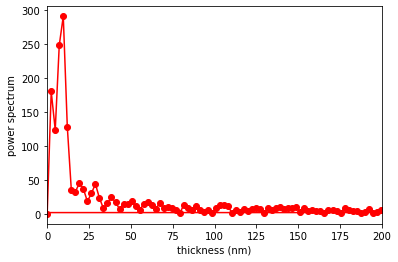

period of q_oscillation = 0.065
thickness = 9.60 nm
ps = 291.3

period of q_oscillation = 0.262
thickness = 2.40 nm
ps = 180.5


center: 8.693
FWHM: 0.127
/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/#1-1360/rock006.png


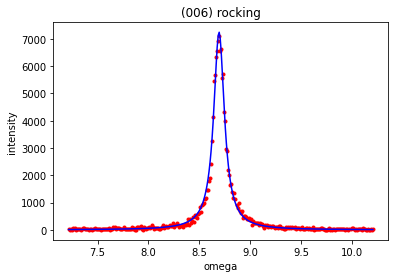

center: 22.258
FWHM: 0.109
/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/#1-1360/rock0015.png


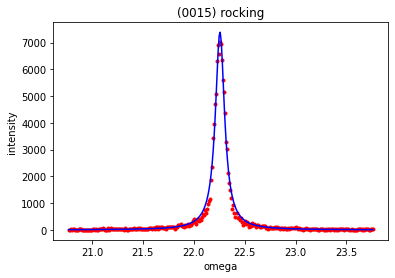

In [81]:
sample = "#1-1360"
filepath_2tw = Path(f"/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/{sample}/2tw.dat")
filepath_r006 = Path(f"/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/{sample}/rock006.dat")
filepath_r0015 = Path(f"/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/{sample}/rock0015.dat")
xrd = XRD(sample, filepath_2tw, filepath_r006, filepath_r0015)
xrd.run()


In [83]:
# # plt.figure(figsize=(12, 6))
# # plt.xlim(0, 5)
# # plt.plot(df["2theta"], df["int_log"])
# filepath = Path(f"/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/{SAMPLE}/2tw.dat")
# df, two_theta_omega_path = two_theta_omega(filepath)


In [20]:
# def low_angle(df: pd.DataFrame)-> List[float]:
#     # 低角反射（two_theta_min~two_theta_max）で膜厚を求める
#     two_theta_min = 0.5
#     two_theta_max = 5
#     t_upperbound = 200 # nm

#     df_trim = df.loc[df.index[(df["2theta"] > two_theta_min) & (df["2theta"] < two_theta_max)].tolist()] # 低角反射のみ抽出


#     def xrd_ref_bg(q, a, b, c):  # XRD強度の背景
#         return -a * np.log10((q - b)) + c

#     param_a = np.linspace(0.1, 500, 51)
#     param_b = np.linspace(-10, 0, 16)
#     param_c = np.linspace(-5,5,11)

#     for a, b, c in itertools.product(param_a, param_b, param_c):
#         # print(a, b, c)
#         param_init = [a, b, c]
#         try:
#             param_opti, _ = optimize.curve_fit(xrd_ref_bg, df_trim["q_lnsp"].values, df_trim["int_log"].values, p0 = param_init) # 最適化
#         except (RuntimeError) as e:
#             # print("cannot optimize")
#             continue
#         if np.isnan(param_opti).any():
#             # print("cannot optimize")
#             continue
#         print(param_opti)
#         df_trim["int_bg_log"] = xrd_ref_bg(df_trim.loc[:, "q_lnsp"], *param_opti)
#         df_trim["int_osci"] = df_trim["int_log"] - df_trim["int_bg_log"]
#         plt.subplot(2, 1, 1)
#         plt.plot(df_trim["q_lnsp"], df_trim["int_log"], color = "red")
#         plt.xlabel("angle(deg)")
#         plt.ylabel("intensity")
#         plt.plot(df_trim["q_lnsp"], df_trim["int_bg_log"], color="blue")
#         # plt.title("contradict from ")
#         plt.subplot(2, 1, 2)
#         plt.plot(df_trim["q_lnsp"], df_trim["int_osci"], color="red")
#         plt.xlabel("q")
#         plt.ylabel("intensity")
#         # plt.title("contradict from ")
#         plt.savefig(f"../Data/XRD/{SAMPLE}/2tw_low_angle.png", format="png", dpi=300)
#         break
#     return df_trim, param_opti

<ipython-input-20-8908d6af03db>:11: RuntimeWarning: invalid value encountered in log10
  return -a * np.log10((q - b)) + c
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[8.07564736 0.02338654 0.31883346]


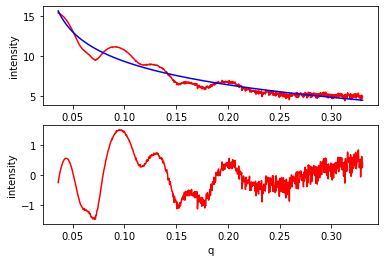

In [21]:
df_trim, param_opti = low_angle(df)

In [22]:
# # ラウエフリンジの解析（各レイヤー層での干渉．(sinN/N)^2(0次の場合)のフィッティング）
# two_theta_min = 14 #(0015)のピークが入る範囲を勘で定める
# two_theta_max = 23
# thick_init = 40 #nm

# df_trim = df.loc[df.index[(df["2theta"] > two_theta_min) & (df["2theta"] < two_theta_max)].tolist()]

# plt.plot(df_trim["q"], df_trim["int_log"], color = "red")
# # 初期値推定
# # 2theta_omegaの最大値からd_initを推定
# two_theta_peak = df_trim["2theta"].values[np.argmax(df_trim["int_log"])]
# q_peak = df_trim["q"].values[np.argmax(df_trim["int_log"])]
# d_init = 2 * np.pi / q_peak
# M_init = thick_init / d_init

# def laue_func(q, d, M, A):
#     return np.log(np.sin(q * d * M / 2)**2) - np.log(np.sin(q * d / 2)**2) + A

# param_init = [M_init, 10]
# # param_opti, _ = optimize.curve_fit(lambda q, M, A: laue_func(q, d_init, M, A), df_trim["q_lnsp"].values, df_trim["int_log"].values, p0 = param_init)
# # plt.plot(df_trim["q"], laue_func(df_trim["q"].values, d_init, *param_opti))
# plt.plot(df_trim["q"], laue_func(df_trim["q"].values, d_init, M_init, 3), color = "blue")
# plt.ylim(bottom = np.min(df_trim["int_log"]) - 2, top = np.max(df_trim["int_log"]) + 2)
# plt.ylabel("intensity")
# plt.xlabel("q")
# plt.savefig(f"../Data/XRD/{SAMPLE}/laue_fringe.png", format="png", dpi=300)


period of q_oscillation = 0.098
thickness = 6.40 nm
ps = 327.8

period of q_oscillation = 0.049
thickness = 12.80 nm
ps = 166.4

period of q_oscillation = 0.037
thickness = 17.07 nm
ps = 111.9




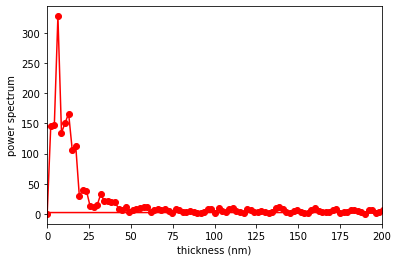

In [30]:
int_fft = fft(df_trim["int_osci"].values) # 低角反射（補正済み）をフーリエ変換
N = len(df_trim["int_osci"])
q_spacing = np.abs(df_trim["q_lnsp"].values[1] - df_trim["q_lnsp"].values[0]) # qの間隔
df_trim["q_freq"] = fftfreq(N, q_spacing) # qの周波数

# ps = power spectrum
df_trim["int_ps"] = np.abs(int_fft)
# dq = period of oscillation
# q_freq = inverse of dq
df_trim["q_period"] = 1 / df_trim["q_freq"]
df_trim["thickness"] = 2 * np.pi * df_trim["q_freq"] * 0.1


df_trim.to_csv(os.path.join(filedir, filename + "_fft.csv"), index = False)

plt.plot(df_trim["thickness"], df_trim["int_ps"], "o-", color = "red")
plt.xlim(0, t_upperbound)
plt.xlabel("thickness (nm)")
plt.ylabel("power spectrum")
plt.savefig(f"../Data/XRD/{SAMPLE}/thickness.png", format="png", dpi=300)

#### search preak ####
fft_peak = signal.argrelmax(df_trim["int_ps"].values)
fft_peak_value = df_trim["int_ps"].values[fft_peak]
q_osci = 1/df_trim["q_freq"].values[fft_peak]
thickness_nm = 2 * np.pi * 0.1 * df_trim["q_freq"].values[fft_peak]
fft_result = np.array([fft_peak_value, q_osci, thickness_nm])
fft_result = fft_result[:, fft_result[0,:].argsort()[::-1]]
fft_peak_value = fft_result[0]
q_osci = fft_result[1]
thickness_nm = fft_result[2]

#print(q_osci)
#print(thickness_nm)

for (i, x) in enumerate(fft_peak_value):
    if i == 0:
        fft_result = ""
    if(thickness_nm[i] > 0 and thickness_nm[i] < t_upperbound and x > fft_peak_value[0] * 0.2):
        fft_result += "period of q_oscillation = {:.3f}".format(q_osci[i])
        fft_result += "\nthickness = {:.2f} nm".format(thickness_nm[i])
        fft_result += "\nps = {0:.1f}".format(x)
        fft_result += "\n\n"
        
print(fft_result)
        

fft_result_path = os.path.join(filedir, filename + "_fft_summary.txt")     
with open(fft_result_path, mode='w') as f:
    f.write(fft_result)

## rocking

In [31]:

def rocking(filepath: str, title: str) -> None:
    """_description_

    Args:
        filename (str): ファイル名

    Returns:
        _type_: _description_
    """
    filedir = os.path.dirname(filepath)
    filebasename = os.path.basename(filepath)
    filename, fileext = os.path.splitext(filebasename)

    df = pd.read_csv(filepath, skiprows = 2, delimiter = " ")
    df.columns = ["omega", "int"]
    plt.plot(df["omega"], df["int"], ".", color = "red")

    ###############################################
    def lor(x, a, b, c):
        return c / ((x - a) **2 + b)
    ###############################################

    #初期値設定
    int_max = np.max(df["int"].values)
    omega_max = df["omega"].values[np.argmax(df["int"].values)]
    a = omega_max
    b = 1/400 #半値幅0.1くらい
    c = int_max * b
    #fitting
    param_init = [a, b, c]
    param_opti, _  = optimize.curve_fit(lor, df["omega"].values, df["int"].values, p0 = param_init, maxfev = 1000)
    fit_result = "center: {0:.3f}\nFWHM: {1:.3f}".format(param_opti[0], 2 * np.sqrt(param_opti[1]))
    print(fit_result)
    plt.plot(df["omega"], lor(df["omega"], *param_opti), color="blue")
    plt.xlabel("omega")
    plt.ylabel("intensity")
    plt.title(title)
    plt.savefig(os.path.join(filedir, filename + ".png"), format="png", dpi=300)

    #dfにフィッティング結果を詰める
    df["d_omega"] = df["omega"] - param_opti[0]
    df["lor_fit"] = lor(df["omega"], *param_opti)
    # print(df)
    csv_path = os.path.join(filedir, filename + ".csv"0
    df.to_csv(csv_path, index = False)

    #フィッティングパラメータを出力
    fit_result_path = os.path.join(filedir, filename + "_fit.txt")
    with open(fit_result_path, mode='w') as f:
        f.write(fit_result)
    return csv_path

center: 8.781
FWHM: 0.201


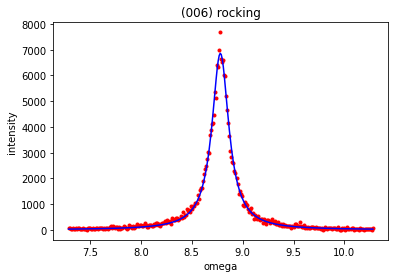

In [32]:
r006_path = rocking(f"/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/{SAMPLE}/rock006.dat", title="(006) rocking")


center: 22.438
FWHM: 0.135


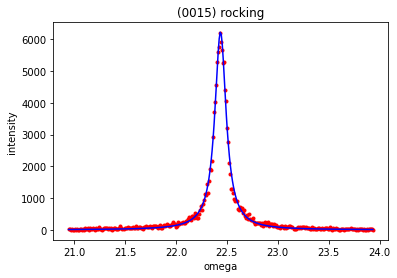

In [33]:
r0015_path = rocking(f"/Users/uedataiga/Desktop/卒業研究/前期/Data/XRD/{SAMPLE}/rock0015.dat", title="(0015) rocking")
